In [66]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from data import *
from window import *
import matplotlib.pyplot as plt
import numpy as np

ticker = 'SPY'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

print(data.columns)

[*********************100%%**********************]  1 of 1 completed
Index(['Open', 'High', 'Low', 'Close', 'RSI', 'MACD', 'MACD Signal', 'EMA_5',
       'EMA_8', 'EMA_13'],
      dtype='object')


In [55]:
def generate_ema_signals(data, row):

    last_row = data.iloc[row]

    ema_5_current = pd.Series(last_row['EMA_5'])
    ema_8_current = pd.Series(last_row['EMA_8'])
    ema_13_current = pd.Series(last_row['EMA_13'])

    # Get the previous row
    prev_row = data.iloc[row-1]

    ema_5_prev = pd.Series(prev_row['EMA_5'])
    ema_8_prev = pd.Series(prev_row['EMA_8'])
    ema_13_prev = pd.Series(prev_row['EMA_13'])

    buy_conditions_met = ((ema_5_current > ema_8_current)) #& (ema_8_current > ema_13_current))

    sell_conditions_met = ((ema_5_current < ema_8_current)) #& (ema_8_current < ema_13_current))
    
    if (buy_conditions_met.all() == True): 
         return 'Buy'

    elif(sell_conditions_met.all()):
        return 'Sell'
    else: 
        return ' '


def generate_macd_signals(data, row):
    # MACD-based signals

    if data.iloc[row]['MACD'] > data.iloc[row]['MACD Signal'] and data.iloc[row-1]['MACD'] < data.iloc[row-1]['MACD Signal']:
        return 'Buy'
    
    elif data.iloc[row]['MACD'] < data.iloc[row]['MACD Signal'] and data.iloc[row-1]['MACD'] > data.iloc[row-1]['MACD Signal']:
        return 'Sell'
    
    else:
        return ''  # No signal


def generate_rsi_signals(data, row):
    
    # RSI-based signals
    if data.iloc[row]['RSI'] < 50:
        return 'Buy'
    
    elif data.iloc[row]['RSI'] > 50:
        return 'Sell'
    
    else:
        return '' 

def generate_signals(data, row): 
    #fibonacci_levels = calculate_fibonacci_levels(data, row)
    #find_positions_fibonacci(row, fibonacci_levels)

    ema_signal = generate_ema_signals(data, row)
    most_recent_macd_signal = None
    rsi_signal = generate_rsi_signals(data, row)

    #print(find_positions_fibonacci(data, row, fibonacci_levels))

    for i in range(row, -1, -1):
        macd_signal = generate_macd_signals(data, i)
        if macd_signal != '':
            most_recent_macd_signal = macd_signal
            break
    
    buy_conditions = ((ema_signal == 'Buy') & ((most_recent_macd_signal == 'Buy') & (rsi_signal == 'Buy')))
    
    sell_conditions = ((ema_signal == 'Sell') & (((most_recent_macd_signal == 'Sell') & (rsi_signal == 'Sell')))) 

    if buy_conditions == True: 

        return 'Buy'#, entry_level, stop_loss, target_profit

    elif sell_conditions == True:
        return 'Sell'
    else: 
        return ' '


In [60]:
def backtest_strategy(data):
    """ Simulate trading based on provided buy and sell signals, including tracking entry and exit prices. """
    capital = 10000
    shares = 0
    #create portforlio dataframe 
    portfolio = pd.DataFrame(index=data.index, columns=['Portfolio Value', 'Entry Price', 'Exit Price'])
    entry_price = None
    exit_price = None
    prev_signal = None 

    for row_index in range(0, len(data)): 
        signal = generate_signals(data, row_index)
    
        if signal == 'Buy' and prev_signal != 'Buy' and capital > 0:  # Check if signal is 'Buy' and different from previous
            shares_to_buy = capital / data.iloc[row_index]['Close']
            shares += shares_to_buy
            capital -= shares_to_buy * data.iloc[row_index]['Close']
            entry_price = data.iloc[row_index]['Close']
            portfolio.loc[data.index[row_index], 'Entry Price'] = entry_price
            # Reset exit price when entering a new position
            exit_price = None

        if signal == 'Sell' and prev_signal != 'Sell' and shares > 0:  # Check if signal is 'Sell' and different from previous
            capital += shares * data.iloc[row_index]['Close']
            shares = 0
            exit_price = data.iloc[row_index]['Close']
            portfolio.loc[data.index[row_index], 'Exit Price'] = exit_price
            # Reset entry price when exiting the position
            entry_price = None

        # Calculate portfolio value
        portfolio_value = capital + (shares * data.iloc[row_index]['Close'])
        portfolio.loc[data.index[row_index], 'Portfolio Value'] = portfolio_value
        
        prev_signal = signal  # Update previous signal for next iteration

    return portfolio.fillna(0)

# Running the backtest
data = fetch_data(ticker, start_date, end_date)

# Assuming generate_buy_signals and generate_sell_signals functions are defined
# and return lists of timestamps where signals occur

portfolio = backtest_strategy(data)

# Display results
print(portfolio)

[*********************100%%**********************]  1 of 1 completed
                     Portfolio Value  Entry Price  Exit Price
Datetime                                                     
2024-03-01 09:30:00     10000.000000   509.070007         0.0
2024-03-01 09:45:00     10000.196029     0.000000         0.0
2024-03-01 10:00:00     10015.516264     0.000000         0.0
2024-03-01 10:15:00     10025.536523     0.000000         0.0
2024-03-01 10:30:00     10022.590093     0.000000         0.0
...                              ...          ...         ...
2024-04-26 14:45:00     10290.585808     0.000000         0.0
2024-04-26 15:00:00     10290.585808     0.000000         0.0
2024-04-26 15:15:00     10290.585808     0.000000         0.0
2024-04-26 15:30:00     10290.585808     0.000000         0.0
2024-04-26 15:45:00     10290.585808     0.000000         0.0

[1040 rows x 3 columns]


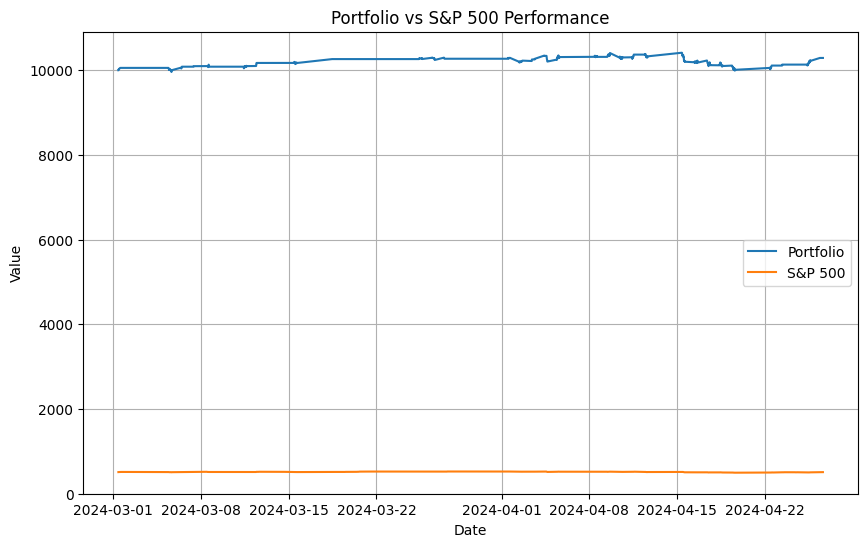

In [67]:
sp500_data = data['Close']*19.643

plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio')
plt.plot(sp500_data.index, sp500_data, label='S&P 500')
plt.title('Portfolio vs S&P 500 Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()